# CNN

In [1]:
import json
import os
import sys
import numpy as np
from gensim.models import Word2Vec
from keras.preprocessing import sequence
from keras.layers import merge, Dense, Input,Dropout, Embedding, LSTM, Bidirectional, Activation
from keras.layers import Conv2D,Conv1D
from keras.layers.merge import dot, multiply, add, concatenate
from keras.layers import Merge
from keras.layers.core import Lambda,Reshape, Flatten, Dropout
from keras.layers.pooling import GlobalMaxPooling2D, GlobalMaxPooling1D,MaxPooling1D
from keras.models import Model
from keras.backend import transpose,batch_dot,expand_dims
from keras import optimizers
from HomeDepotCSVReader import HomeDepotReader
import Utilities
from DataPreprocessing import DataPreprocessing
from Feature_Word2Vec import Feature_Word2Vec
from AutomaticQueryExpansion import Word2VecQueryExpansion
import re
from nltk.corpus import stopwords
from keras.utils.np_utils import to_categorical
import pandas as pd
from FeatureEngineering import HomeDepotFeature
from keras.layers.wrappers import TimeDistributed
from keras.callbacks import ModelCheckpoint,EarlyStopping

Using TensorFlow backend.


In [2]:
# train_filename = '../data/train_play.csv'
# test_filename = '../data/test_play.csv'
# soln_filename = '../data/solution.csv'
# attribute_filename = '../data/attributes_play.csv'
# description_filename = '../data/product_descriptions_play.csv'
# word2vec_model_path='model/word2vec_play.model'
# vocab_path='model/word2vec_play_vocab.json'
# embeddings_path='model/embeddings_play.npz'

train_filename = '../data/train.csv'
test_filename = '../data/test.csv'
soln_filename = '../data/solution.csv'
attribute_filename = '../data/attributes.csv'
description_filename = '../data/product_descriptions.csv'
word2vec_model_path='model/word2vec_cnn.model'
vocab_path='model/word2vec_cnn_vocab.json'
embeddings_path='model/embeddings_cnn.npz'

In [3]:
reader = HomeDepotReader()

train_query_df, product_df, attribute_df, test_query_df = reader.getQueryProductAttributeDataFrame(train_filename,
                                              test_filename,
                                              attribute_filename,
                                              description_filename)
print("train_query_df:",list(train_query_df))
print("product_df:", list(product_df))
print("attribute_df:", list(attribute_df))
print("test_query_df:", list(test_query_df))

===========Tranforming labels...
showing current values
trainDF: ['id', 'product_uid', 'search_term', 'relevance']
trainDF:    id  product_uid    search_term  relevance
0   2       100001  angle bracket        3.0
self.mergedLabelDF: ['relevance'] 
 <class 'pandas.core.frame.DataFrame'> (74067, 1)    relevance
0        3.0
Old unique Labels: [ 1.    1.25  1.33  1.5   1.67  1.75  2.    2.25  2.33  2.5   2.67  2.75
  3.  ]
newLabels: [ 0  1  2  3  4  5  6  7  8  9 10 11 12]
Creating new column for training:  relevance_int
===========Transform labels completed
train_query_df: ['id', 'product_uid', 'search_term', 'relevance', 'relevance_int', 'product_idx']
product_df: ['product_title', 'product_uid', 'product_description']
attribute_df: ['product_uid', 'name', 'value']
test_query_df: ['id', 'product_uid', 'search_term']


In [4]:
#transform attribute into doc
dp = DataPreprocessing()
attribute_doc_df = dp.getAttributeDoc(attribute_df)
#attribute_doc_df
product_df=product_df.join(attribute_doc_df.set_index('product_uid'), on = 'product_uid')

In [5]:
### test data
soln_df = pd.read_csv(soln_filename, delimiter=',', low_memory=False, encoding="ISO-8859-1")
test_private_df = dp.getGoldTestSet(test_query_df, soln_df, testsetoption='Private')#,savepath='../data/test_private_gold.csv')
test_public_df = dp.getGoldTestSet(test_query_df, soln_df, testsetoption='Public')# savepath='../data/test_public_gold.csv')

In [6]:

train_query_df = HomeDepotFeature().getFeature(train_query_df, product_df, attribute_df, test_private_df,
                        features="spelling,nonascii")
#,stopwords,stemming
#"spelling,nonascii" no diff.

Performing spell correction
Performing non-ascii removal
Non-ascii clean on search_term took: 0.01 minutes
Non-ascii clean on product_title took: 0.03 minutes
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74067 entries, 0 to 74066
Data columns (total 6 columns):
id               74067 non-null int64
product_uid      74067 non-null int64
search_term      74067 non-null object
relevance        74067 non-null float64
relevance_int    74067 non-null int64
product_idx      74067 non-null object
dtypes: float64(1), int64(3), object(2)
memory usage: 3.4+ MB
None


In [7]:
test_private_df = HomeDepotFeature().getFeature(test_private_df, product_df, attribute_df, test_private_df,
                        features="spelling,nonascii")

Performing spell correction
Performing non-ascii removal
Non-ascii clean on search_term took: 0.01 minutes
Non-ascii clean on product_title took: 0.03 minutes
<class 'pandas.core.frame.DataFrame'>
Int64Index: 78419 entries, 2 to 147405
Data columns (total 4 columns):
id             78419 non-null int64
product_uid    78419 non-null int64
search_term    78419 non-null object
relevance      78419 non-null float64
dtypes: float64(1), int64(2), object(1)
memory usage: 3.0+ MB
None


In [8]:
test_public_df = HomeDepotFeature().getFeature(test_public_df, product_df, attribute_df, test_public_df,
                        features="spelling,nonascii")

Performing spell correction
Performing non-ascii removal
Non-ascii clean on search_term took: 0.0 minutes
Non-ascii clean on product_title took: 0.03 minutes
<class 'pandas.core.frame.DataFrame'>
Int64Index: 33648 entries, 1 to 147404
Data columns (total 4 columns):
id             33648 non-null int64
product_uid    33648 non-null int64
search_term    33648 non-null object
relevance      33648 non-null float64
dtypes: float64(1), int64(2), object(1)
memory usage: 1.3+ MB
None


In [9]:
# product_df['content'] = train_query_df['search_term'].map(str) + " " + \
#                         product_df['product_title'].map(str) + " " + \
#                         product_df['product_description'].map(str) + " " + \
#                         product_df['attr_json'].map(str)

# product_df['content'] = product_df['product_title'].map(str) + " " + \
#                         product_df['product_description'].map(str) 

product_df['content'] = product_df['product_title'].map(str)# + " " + \
#                         product_df['product_description'].map(str) 

# ## no attribute
# product_df['content'] = product_df['product_title'].map(str) + " " + \
#                         product_df['product_description'].map(str) 
        
#product_df['content']

In [10]:
len(test_public_df)

33648

In [11]:
#https://www.kaggle.com/c/word2vec-nlp-tutorial/details/part-2-word-vectors
def doc_to_wordlist( doc, vocab=['<PAD>', '<OOV>'], remove_stopwords=False, remove_non_letters=False, remove_non_letters_numbers=True):
    # Function to convert a document to a sequence of words,
    # optionally removing stop words.  Returns a list of words.
    #
    # 1. Remove HTML
    #review_text = BeautifulSoup(review).get_text()
    #  
    # 2. Remove non-letters
    if remove_non_letters:
        doc = re.sub("[^a-zA-Z]"," ", doc)
    # 2a. remove non-letters, numbers
    if remove_non_letters_numbers:
        doc = re.sub("[^a-zA-Z0-9]"," ", doc)
    #
    # 3. Convert words to lower case and split them
    words = doc.lower().split()
    #
    # 4. Optionally remove stop words (false by default)
    if remove_stopwords:
        stops = set(stopwords.words("english"))
        #words = [w for w in words if not w in stops]
        new_words = []
        for w in words:
            if not w in stops:
                new_words.append(w)
                #if w not in vocab: #TODO: temp removal, too slow
                #    vocab.append(w)
    
    # 5. Return a list of words
    return new_words,vocab

# words,vocab=doc_to_wordlist(product_df['content'][0],remove_stopwords=True, remove_non_letters=False, remove_non_letters_numbers=True)
# print(len(words),len(vocab))
# print(vocab)
# words,vocab=doc_to_wordlist(product_df['content'][0],remove_stopwords=False, remove_non_letters=False, remove_non_letters_numbers=True)
# print(len(words),len(vocab))
# print(vocab)
# product_df['content'][0]

In [12]:
# # Download the punkt tokenizer for sentence splitting
import nltk.data
# nltk.download()   

# Load the punkt tokenizer
tokenizer = nltk.data.load('tokenizers/punkt/english.pickle')

In [13]:
### tokenisation
class alt_tokenizer():
    def tokenize(self,sentence):
        token = re.compile("[\w]+(?=n't)|n't|\'s|\'m|\'ll|[\w]+|[.?!;,\-\(\)—\:'\"]")
        return token.findall(sentence)

#load alt tokenizer
my_alt_tokenizer = alt_tokenizer()

In [14]:
# Define a function to split a doc into parsed sentences
def doc_to_sentences( doc, tokenizer, vocab=None, remove_stopwords=False, remove_non_letters=False, remove_non_letters_numbers=True ):
    if vocab is None:
        vocab = ['<PAD>', '<OOV>']
    
    # Function to split a doc into parsed sentences. Returns a 
    # list of sentences, where each sentence is a list of words
    #
    # 1. Use the NLTK tokenizer to split the paragraph into sentences
    raw_sentences = tokenizer.tokenize(doc.strip())
    #
    # 2. Loop over each sentence
    sentences = []
    for raw_sentence in raw_sentences:
        # If a sentence is empty, skip it
        if len(raw_sentence) > 0:
            # Otherwise, call review_to_wordlist to get a list of words
            (words,vocab) = doc_to_wordlist( raw_sentence, vocab, remove_stopwords )
            sentences.append(words)
    #
    # Return the list of sentences (each sentence is a list of words,
    # so this returns a list of lists
    return sentences,vocab


In [15]:
print(product_df['product_description'][10])
print(product_df['content'][10])
vocab=['<PAD>', '<OOV>']
#retokenise:
tokens=my_alt_tokenizer.tokenize(product_df['content'][10])
print(tokens)
words,vocab=doc_to_wordlist(str(tokens),remove_stopwords=True, \
                            remove_non_letters=False, remove_non_letters_numbers=True)
print(len(words))
#print(len(doc_to_wordlist(product_df['content'][0],remove_stopwords=False)))
print(len(vocab))
print(vocab)

make grilling great with this handsome and functional grill gazebo this grill gazebo is a great gift to anyone who loves to grill yourself included providing shade and protection from harmful uv rays rain and debris this grill gazebo will help keep your grill looking great and keep you cool when grilling in the hot summer sun this grill gazebo comes with a rich brown canopy and black frame its 8 foot width means that you can easily fit most size grills beneath and standing at 8 feet tall even the tallest grill afficionado will fit beneath comfortably upgrade your grilling today with the addition of this stunning grill gazebo vented canopy built in lattice work is great for holding grill accessories2 built in tile shelves versatile design will coordinate easily durable powder coated finish low maintenance easy to clean
sun joy calais 8 ft. x 5 ft. x 8 ft. steel tile fabric grill gazebo
['sun', 'joy', 'calais', '8', 'ft', '.', 'x', '5', 'ft', '.', 'x', '8', 'ft', '.', 'steel', 'tile', 'f

In [16]:
product_df['content'][100]
vocab=None
sentences,vocab = doc_to_sentences(product_df['content'][100],tokenizer,remove_stopwords=True, \
                            remove_non_letters=False, remove_non_letters_numbers=True)
print(len(sentences))
print(len(vocab))
# print(len(doc_to_sentences(product_df['content'][0],tokenizer,remove_stopwords=True)))
# print(len(doc_to_sentences(product_df['content'][0],tokenizer,remove_stopwords=False)))
# product_df['content'][0]

1
2


In [17]:
sentences = []  # Initialize an empty list of sentences
query_sentences = []
doc_sentences = []
vocab=['<PAD>', '<OOV>']
print("Parsing sentences from search string")
for query in train_query_df["search_term"]:
    words,vocab=doc_to_wordlist(query,vocab, remove_stopwords=True, remove_non_letters=False, remove_non_letters_numbers=True)
    query_sentences += [words]
 

Parsing sentences from search string


In [18]:
print(len(query_sentences))
print(len(vocab))

74067
2


In [19]:
print("Parsing sentences from unlabeled set")
for doc in product_df['content']:
    words,vocab=doc_to_wordlist(doc,vocab, remove_stopwords=True,remove_non_letters=False, remove_non_letters_numbers=True)
    doc_sentences += [words]

sentences = query_sentences+doc_sentences   

Parsing sentences from unlabeled set


In [20]:
print(len(sentences))
print(len(vocab))

198495
2


In [125]:
# Import the built-in logging module and configure it so that Word2Vec 
# creates nice output messages
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s',\
    level=logging.INFO)

# Set values for various parameters
num_features = 300#50#300    # Word vector dimensionality                      
min_word_count = 1#5#40   # Minimum word count                        
num_workers = 4       # Number of threads to run in parallel
context = 10          # Context window size                                                                                    
downsampling = 0 #1e-3   # Downsample setting for frequent words
iterations = 10

# Initialize and train the model (this will take some time)
from gensim.models import word2vec
print("Training model...")
word2vec_model = word2vec.Word2Vec(sentences, workers=num_workers, \
            size=num_features, min_count = min_word_count, \
            window = context, sample = downsampling, iter=iterations)

# If you don't plan to train the model any further, calling 
# init_sims will make the model much more memory-efficient.
word2vec_model.init_sims(replace=True)

# It can be helpful to create a meaningful model name and 
# save the model for later use. You can load it later using Word2Vec.load()
#model_name = "300features_40minwords_10context"
word2vec_model.save(word2vec_model_path)

2017-04-05 11:18:50,640 : INFO : collecting all words and their counts
2017-04-05 11:18:50,641 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2017-04-05 11:18:50,653 : INFO : PROGRESS: at sentence #10000, processed 29172 words, keeping 3572 word types
2017-04-05 11:18:50,664 : INFO : PROGRESS: at sentence #20000, processed 59500 words, keeping 4877 word types
2017-04-05 11:18:50,676 : INFO : PROGRESS: at sentence #30000, processed 89924 words, keeping 5430 word types
2017-04-05 11:18:50,687 : INFO : PROGRESS: at sentence #40000, processed 119667 words, keeping 5752 word types
2017-04-05 11:18:50,698 : INFO : PROGRESS: at sentence #50000, processed 149568 words, keeping 6001 word types
2017-04-05 11:18:50,709 : INFO : PROGRESS: at sentence #60000, processed 183701 words, keeping 6510 word types
2017-04-05 11:18:50,721 : INFO : PROGRESS: at sentence #70000, processed 220154 words, keeping 6767 word types
2017-04-05 11:18:50,745 : INFO : PROGRESS: at sentence #

Training model...


2017-04-05 11:18:50,864 : INFO : PROGRESS: at sentence #120000, processed 760715 words, keeping 17720 word types
2017-04-05 11:18:50,895 : INFO : PROGRESS: at sentence #130000, processed 877727 words, keeping 19133 word types
2017-04-05 11:18:50,922 : INFO : PROGRESS: at sentence #140000, processed 989816 words, keeping 20489 word types
2017-04-05 11:18:50,951 : INFO : PROGRESS: at sentence #150000, processed 1101386 words, keeping 21516 word types
2017-04-05 11:18:50,984 : INFO : PROGRESS: at sentence #160000, processed 1215308 words, keeping 22616 word types
2017-04-05 11:18:51,018 : INFO : PROGRESS: at sentence #170000, processed 1334055 words, keeping 23694 word types
2017-04-05 11:18:51,051 : INFO : PROGRESS: at sentence #180000, processed 1452891 words, keeping 24550 word types
2017-04-05 11:18:51,082 : INFO : PROGRESS: at sentence #190000, processed 1564299 words, keeping 25332 word types
2017-04-05 11:18:51,107 : INFO : collected 25971 word types from a corpus of 1658493 raw wo

In [22]:
print(len(word2vec_model.wv.vocab))
#word2vec_model.wv.vocab

25971


In [23]:
print(word2vec_model.most_similar('wood', [], 3))
#print(word2vec_model.most_similar('temperature'))

[('mahogany', 0.541217565536499), ('cedar', 0.5299957394599915), ('maple', 0.4930189549922943)]


In [24]:
# #w2v=Feature_Word2Vec(modelFilename=word2vec_model_path)#modelFilename=word2vec_model_path
# w2v=Feature_Word2Vec()
# #sentences=w2v.convertDFIntoSentences(product_df,'content')
# #print(sentences)
# w2v.trainModel(sentences)

In [25]:
# len(w2v.model.wv.vocab)

In [26]:
# w2vExpand=Word2VecQueryExpansion(modelFilename=word2vec_model_path)
# query="cooking"
# print("Expanding query: ")
# print(w2vExpand.getExpandedQuery(query,maxNoOfAdditionalWords=2,minSimilarityLevel=0.65,))

In [27]:
# print(w2v.getVectorFromWord('wood'))
# print(w2v.getSimilarWordVectors('wood',5))
# print(len(w2v.getVectorFromWord('wood')))

# embeddings to keras
http://ben.bolte.cc/resources/embeddings/embeddings.html

In [28]:
#vocab = dict([(k, v.index) for k, v in w2v.model.wv.vocab.items()])
#vocab = dict([(k, v.index) for k, v in word2vec_model.wv.vocab.items()])
word2vec_vocab = dict([(k, v.index+2) for k, v in word2vec_model.wv.vocab.items()]) # Leave room for <pad>
word2vec_vocab['<PAD>']=0
word2vec_vocab['<OOV>']=1
with open(vocab_path, 'w') as f:
    f.write(json.dumps(word2vec_vocab))

In [29]:
#weights = w2v.model.wv.syn0
weights = word2vec_model.wv.syn0
np.save(open(embeddings_path, 'wb'), weights)

In [30]:
def load_vocab(vocab_path):
    """
    Load word -> index and index -> word mappings
    :param vocab_path: where the word-index map is saved
    :return: word2idx, idx2word
    """

    with open(vocab_path, 'r') as f:
        data = json.loads(f.read())
    word2idx = data
    idx2word = dict([(v, k) for k, v in data.items()])
    return word2idx, idx2word

In [31]:
word2idx, idx2word = load_vocab(vocab_path)

In [32]:
def word2vec_embedding_layer(embeddings_path,masking=True,trainable=False):
    """
    Generate an embedding layer word2vec embeddings
    :param embeddings_path: where the embeddings are saved (as a numpy file)
    :return: the generated embedding layer
    """

    saved_weights = np.load(open(embeddings_path, 'rb'))
    padding_weight = np.zeros(num_features)
    padding_weight=np.expand_dims(padding_weight,axis=0)
    oov_weight = np.random.rand(num_features)
    oov_weight=np.expand_dims(oov_weight,axis=0)    
    weights=np.concatenate((padding_weight,saved_weights), axis=0)
    layer = Embedding(input_dim=weights.shape[0], output_dim=weights.shape[1], weights=[weights],mask_zero=masking, trainable=trainable)
    return layer

In [33]:
#a = np.load(open(embeddings_path, 'rb'))
# b = np.zeros(50)
# b=np.expand_dims(b,axis=0)
# b.shape

In [34]:
# c=np.concatenate((b,a), axis=0)
# c[0:2]

In [35]:
# idx2word = []
# idx2word=[dict([(v, k) for k, v in word2idx.items()])]
# idx2word.insert(0, '<PAD>')

In [36]:
idx2word[0]

'<PAD>'

In [37]:
idx2word[1]

'<OOV>'

In [38]:
idx2word[2]

'x'

In [39]:
print_tokens=False

In [40]:
# variable arguments are passed to gensim's word2vec model
# if options.train:
#     print('Training Word2Vec...')
#     create_embeddings(options.data, options.embeddings, options.vocab, size=100, min_count=5, window=5, sg=1, iter=25)

word2idx, idx2word = load_vocab(vocab_path)

if print_tokens:
    print('Tokens:', ', '.join(word2idx.keys()))



# convert to idx

In [41]:
len(word2idx.keys())

25973

In [42]:
#todo need to pass in word2idx
def convert_word2idx(word,verbose=False):
    if verbose:
        print("word: {}".format(word))
    if str(word) not in word2idx.keys():
        return 1
    else:
        return word2idx[word]

In [43]:
#convert_word2idx('bracket')
for word in doc_sentences[100]:
    idx=convert_word2idx(word)
    #print(idx)

In [44]:
def query_sent2idx(sentences):
    query_word2vec_idx_list=[]
    queries=sentences #w2v.convertDFIntoSentences(df,col)
    print(len(queries))
    for query in queries:
        idx_list = []
        for word in query:
#             if word not in word2idx.keys():
#                 idx_list+=[0]#[len(word2idx.keys())] # use last as special key #TODO: well we need to fix this. Using 0 for now so it's in range To OOV or something random
#             else:
#                 idx_list+=[word2idx[word]]
            idx_list+=[convert_word2idx(word)]
        query_word2vec_idx_list+=[idx_list]
        #print("=====")
        #print(idx_list)
        #print("=====")
    return query_word2vec_idx_list


In [45]:
#query_word2vec_idx_list = query_sent2idx(train_query_df['search_term'])
query_word2vec_idx_list = query_sent2idx(query_sentences)
#print(query_word2vec_idx_list)

74067


In [46]:
# def doc_sent2idx(df,col):
#     doc_word2vec_idx_list=[]
#     for row in df.iteritems():
#         a=w2v.convertDFIntoSentences(row,col)
#         print(a)
# #    print(len(queries))
# #     for query in queries:
# #         idx_list = []
# #         for word in query:
# #             if word not in word2idx.keys():
# #                 idx_list+=[len(word2idx.keys())] # use last as special key
# #             else:
# #                 idx_list+=[word2idx[word]]
# #         query_word2vec_idx_list+=[idx_list]
# #         print("=====")
# #         print(idx_list)
# #         print("=====")
#     return doc_word2vec_idx_list

In [47]:
#TODO: this is fucked. just bodge for testing nn
#doc_word2vec_idx_list = query_sent2idx(product_df,'product_title')
joined_df=train_query_df.join(product_df.set_index('product_uid'), on='product_uid')

joined_doc_sentences=[]
for doc in joined_df['content']:
    words,vocab = doc_to_wordlist(doc,vocab, remove_stopwords=True)
    joined_doc_sentences+=[words]
    
doc_word2vec_idx_list = query_sent2idx(joined_doc_sentences)
#print(doc_word2vec_idx_list)

74067


In [48]:
len(joined_doc_sentences)

74067

In [49]:
doc_word2vec_idx_list[0:10]
#query_word2vec_idx_list[100:110]
#query_sent2idx(joined_doc_sentences[0])

[[484, 523, 391, 16, 256, 369],
 [484, 523, 391, 16, 256, 369],
 [120, 78, 907, 188, 3, 36, 1335, 10807, 12932, 23, 276, 921],
 [192, 3260, 3, 50, 24, 57, 92, 20, 42, 115, 452],
 [192, 3260, 3, 50, 24, 57, 92, 20, 42, 115, 452],
 [342, 3, 55, 113, 5, 181, 721, 548, 31, 17, 593, 1346],
 [342, 3, 55, 113, 5, 181, 721, 548, 31, 17, 593, 1346],
 [342, 3, 55, 113, 5, 181, 721, 548, 31, 17, 593, 1346],
 [564, 47, 4840, 4, 12, 18, 35, 1644, 351, 679],
 [212, 1383, 7, 6, 2, 7, 2, 9, 5, 751, 1910, 1267]]

In [50]:
# # cosine similarity model
# print('Building model...')
# input_a = Input(shape=(1,), dtype='int32', name='input_a')
# input_b = Input(shape=(1,), dtype='int32', name='input_b')
# embeddings = word2vec_embedding_layer(embeddings_path)
# embedding_a = embeddings(input_a)
# embedding_b = embeddings(input_b)
# similarity = merge([embedding_a, embedding_b], mode='cos', dot_axes=2)
# model = Model(input=[input_a, input_b], output=similarity)
# model.compile(optimizer='sgd', loss='mse') # optimizer and loss don't matter


# word_a = 'wood'#raw_input('First word: ')
# if word_a not in word2idx:
#     print('"%s" is not in the index' % word_a)
# word_b = 'fan'#raw_input('Second word: ')
# if word_b not in word2idx:
#     print('"%s" is not in the index' % word_b)
# output = model.predict([np.asarray([word2idx[word_a]]), np.asarray([word2idx[word_b]])])
# print('%f' % output)

# GLOVE

In [51]:
word2vec_vocab['wood']

23

In [52]:
import csv
### GLOVE
vocab_size=len(word2vec_vocab)#word2vec_model.wv.vocab)
input_size=num_features
LOAD_GLOVE=False
pretrainedEmbedding='../data/glove.6B.100d.txt'
### Load GloVe Pre-Trained Embedding ###

if LOAD_GLOVE:
    # Read in the pre-trained embeddings. Delimiter by space, without any quote
    pretrain_embeddings = pd.read_csv(pretrainedEmbedding, header=None, delimiter=' ', quoting=csv.QUOTE_NONE)

    # Convert data frame into a dict
    pretrain_embeddings = pretrain_embeddings.set_index(0).T.to_dict('list')

    pretrain_embeddings_sorted = np.random.rand(vocab_size, input_size)

    count = 0
    for word,index in word2vec_vocab.items():
        if word in pretrain_embeddings:
            count+=1
            pretrain_embeddings_sorted[index] = pretrain_embeddings[word]

    print("Number of pre-trained word/embedding matched: ", count, " out of ", vocab_size)

# Define model

In [53]:
lengths=[]
for i in doc_word2vec_idx_list:
    lengths+=[len(i)]

(array([  1.00000000e+00,   2.50000000e+01,   0.00000000e+00,
          1.56000000e+02,   7.17000000e+02,   0.00000000e+00,
          1.71700000e+03,   3.11900000e+03,   0.00000000e+00,
          4.87300000e+03,   6.46700000e+03,   0.00000000e+00,
          7.25600000e+03,   7.65100000e+03,   0.00000000e+00,
          7.52800000e+03,   6.83900000e+03,   0.00000000e+00,
          6.40900000e+03,   5.32300000e+03,   0.00000000e+00,
          4.27700000e+03,   3.23200000e+03,   0.00000000e+00,
          2.69900000e+03,   1.88300000e+03,   0.00000000e+00,
          1.16500000e+03,   8.39000000e+02,   0.00000000e+00,
          6.56000000e+02,   3.86000000e+02,   0.00000000e+00,
          3.17000000e+02,   2.18000000e+02,   0.00000000e+00,
          1.48000000e+02,   1.08000000e+02,   0.00000000e+00,
          3.30000000e+01,   1.40000000e+01,   0.00000000e+00,
          8.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   2.00000000e+00,   0.00000000e+00,
        

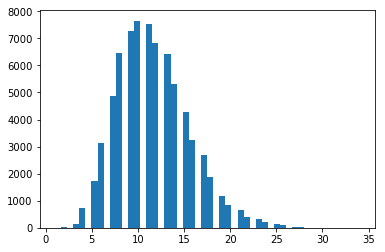

In [54]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.hist(lengths,bins=50)

In [90]:
query_min_len = len(min(query_word2vec_idx_list,key=len)) #400 # todo: confirm this is sensible
doc_min_len = len(min(doc_word2vec_idx_list,key=len)) #400 # todo: confirm this is sensible
query_max_len = 6 #covers 95.74% of the search lengths (see data exploration)
# find longest sub list
doc_max_len = 6 #len(max(doc_word2vec_idx_list,key=len)) #400 # todo: confirm this is sensible
query_filter_size_m=2
doc_filter_size_m=2
num_filters=100 #aka featuremaps

# Model Hyperparameters
embedding_dim = num_features#100 #50
#filter_sizes = (3, 8)
#num_filters = 10
dropout_prob = 0.2 #0.5 from paper #(0.5, 0.8)
hidden_dims = 50
#https://github.com/alexander-rakhlin/CNN-for-Sentence-Classification-in-Keras/blob/master/sentiment_cnn.py

print(doc_max_len)
print(query_max_len)
print(doc_min_len)
print(query_min_len)

6
6
1
0


In [91]:
#TODO testing
#doc_max_len=doc_min_len
print('Building model...')

embeddings = word2vec_embedding_layer(embeddings_path,masking=False,trainable=True)

## embedding lookup
input_query = Input(shape=(query_max_len+(query_filter_size_m-1)*2,), dtype='int32', name='input_query')
input_doc = Input(shape=(doc_max_len+(doc_filter_size_m-1)*2,), dtype='int32', name='input_doc')
input_exact_match = Input(shape=(query_max_len,doc_max_len), dtype='float32', name='input_exact_match')
embedding_query = embeddings(input_query)  # (None, 6, 100)
embedding_doc = embeddings(input_doc)      # (None, 400, 100)
#TODO: do we want drop out here? 

## convolution layer
# include bias vector to result of each feature map
# relu activation
conv_query_output = Conv1D(filters=num_filters,
            kernel_size=query_filter_size_m,
            strides=1, 
            padding='same', # 'valid', #The valid means there is no padding around input or feature map, while same means there are some padding around input or feature map, making the output feature map's size same as the input's
            dilation_rate=1, 
            activation='relu', 
            use_bias=True, 
            kernel_initializer='glorot_uniform', 
            bias_initializer='glorot_uniform',#'zeros', 
            kernel_regularizer=None, bias_regularizer=None, activity_regularizer=None, 
            kernel_constraint=None, bias_constraint=None)(embedding_query)

conv_doc_output = Conv1D(filters=num_filters,
            kernel_size=doc_filter_size_m,
            strides=1, 
            padding='same', # 'valid', #The valid means there is no padding around input or feature map, while same means there are some padding around input or feature map, making the output feature map's size same as the input's
            dilation_rate=1, 
            activation='relu', 
            use_bias=True, 
            kernel_initializer='glorot_uniform', 
            bias_initializer='glorot_uniform',#'zeros', 
            kernel_regularizer=None, bias_regularizer=None, activity_regularizer=None, 
            kernel_constraint=None, bias_constraint=None)(embedding_doc)
#TODO: do we want drop out here?

## Pooling layer
# TODO: sliding Max Pooling instead of original Global Pooling?
conv_query_output=GlobalMaxPooling1D()(conv_query_output)
conv_doc_output=GlobalMaxPooling1D()(conv_doc_output)

## similarity matrix
#cos_distance = merge([conv_query_output, conv_doc_output], mode='cos', dot_axes=1) # magic dot_axes works here!
#cos_distance = Reshape((1,))(cos_distance)
#cos_similarity = Lambda(lambda x: 1-x)(cos_distance)
#similarity_output=dot([conv_query_output, conv_doc_output], axes=1, normalize=True)
similarity_output = Dense(num_filters,activation='linear',use_bias=False, \
                          kernel_initializer='glorot_uniform', bias_initializer='zeros', kernel_regularizer=None, \
                          bias_regularizer=None, activity_regularizer=None, kernel_constraint=None, \
                          bias_constraint=None)(conv_doc_output)
#TODO: is bias needed?
similarity_output = dot([conv_query_output, similarity_output], axes=1, normalize=True)

## Concatenate (join layer)
concat_output = concatenate([conv_query_output,conv_doc_output,similarity_output])

## Hidden layer
hidden_output = Dense(embedding_dim*2+1,activation='relu',use_bias=True, \
                          kernel_initializer='glorot_uniform', bias_initializer='glorot_uniform', \
                          kernel_regularizer=None, \
                          bias_regularizer=None, activity_regularizer=None, kernel_constraint=None, \
                          bias_constraint=None)(concat_output)

## dropout at softmax layer
dropout_output = Dropout(dropout_prob)(hidden_output) #noise_shape=None, seed=None)

## Final layer
output = Dense(1,activation='sigmoid', kernel_initializer='glorot_uniform')(dropout_output)
#categorical
#output = Dense(13, activation='softmax', kernel_initializer='glorot_uniform')(dropout_output)

# build model
#model = Model([input_query], [query_output])
#model = Model([input_doc], [encoded_doc])
#model = Model([input_query,input_doc], [output1,output2,output3])
#model = Model([input_query,input_doc], [output_combined])
#model = Model([input_query,input_doc,input_exact_match], [query_output])
#model = Model([input_query,input_doc], [query_output,doc_output])
#model = Model([input_query,input_doc], [output])
#model = Model([input_query,input_doc,input_exact_match], [mt_input])
#model = Model([input_query,input_doc,input_exact_match], [mt_input_1,mt_input_2])
model = Model([input_query,input_doc,input_exact_match], [output])
#model = Model([input_query,input_doc,input_exact_match], [similarity_output])



model.summary()

Building model...
____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_doc (InputLayer)           (None, 8)             0                                            
____________________________________________________________________________________________________
embedding_2 (Embedding)          (None, 8, 300)        7791600                                      
____________________________________________________________________________________________________
input_query (InputLayer)         (None, 8)             0                                            
____________________________________________________________________________________________________
conv1d_4 (Conv1D)                (None, 8, 100)        60100                                        
_________________________________________________________________________

In [92]:
# # from keras.layers import Input, merge
# # from keras.models import Model
# # import numpy as np

# # input_a = np.reshape([[1, 2, 3],[1, 2, 3],],[[1, 2, 3],[1, 2, 3]])
# # input_b = np.reshape([4, 5, 6], (1, 1, 3))

# # print(input_a)
# # print(input_b)
# # a = Input(shape=(1, 3))
# # b = Input(shape=(1, 3))

# # concat = merge([a, b], mode='concat', concat_axis=-1)
# # dot = merge([a, b], mode='dot', dot_axes=2)
# # cos = merge([a, b], mode='cos', dot_axes=2)

# # model_concat = Model(input=[a, b], output=concat)
# # model_dot = Model(input=[a, b], output=dot)
# # model_cos = Model(input=[a, b], output=cos)

# # print(model_concat.predict([input_a, input_b]))
# # print(model_dot.predict([input_a, input_b]))
# # print(model_cos.predict([input_a, input_b]))

# from keras import backend as K
# x_batch = K.ones(shape=(11, 6,50 ))
# y_batch = K.ones(shape=(11, 400,50))
# x_batch=K.batch_flatten(x_batch)
# y_batch=K.batch_flatten(y_batch)
# #xy_batch_dot = K.dot(transpose(y_batch),x_batch )#, axes=[0,0])
# xy_batch_dot = K.batch_dot(x_batch,y_batch, axes=[0,0])
# K.int_shape(xy_batch_dot)
# # K.int_shape(x_batch)
# # K.int_shape(y_batch)



In [93]:
optimizer = optimizers.Adam(lr=0.001)
#optimizer = optimizers.SGD(lr = 0.001, momentum = 0.9, decay = 0.0, nesterov = True)
model.compile(optimizer=optimizer, loss='mse', metrics=['accuracy'])
#model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

In [94]:
x_query_train=np.array(query_word2vec_idx_list)[0:74067]
x_doc_train=np.array(doc_word2vec_idx_list)[0:74067]#[0:len(x_query_train)]

# TODO: replace this with embedding with mask zero rather than padding, need to change index for encoding too, imput dim too.
print("Pad sequences (samples x time)")
x_query_train = sequence.pad_sequences(x_query_train, maxlen=query_max_len,padding='post', truncating='post', value=0.)
x_doc_train = sequence.pad_sequences(x_doc_train, maxlen=doc_max_len,padding='post', truncating='post', value=0.)
# x_query_test = sequence.pad_sequences(x_query_test, maxlen=query_max_len)
# x_doc_test = sequence.pad_sequences(x_doc_test, maxlen=doc_max_len)

# Padding for wide convolution
# Pad input with m-1 zeros from left and right. m is filter size
padded_x_query_train = sequence.pad_sequences(x_query_train, maxlen=query_max_len+(query_filter_size_m-1),\
                                      padding='post', truncating='post', value=0.)
padded_x_query_train = sequence.pad_sequences(padded_x_query_train, maxlen=query_max_len+(query_filter_size_m-1)*2,\
                                      padding='pre', truncating='pre', value=0.)
padded_x_doc_train = sequence.pad_sequences(x_doc_train, maxlen=doc_max_len+(doc_filter_size_m-1),\
                                      padding='post', truncating='post', value=0.)
padded_x_doc_train = sequence.pad_sequences(padded_x_doc_train, maxlen=doc_max_len+(doc_filter_size_m-1)*2,\
                                      padding='pre', truncating='pre', value=0.)


print('x_query_train shape:', x_query_train.shape)
print('x_doc_train shape:', x_doc_train.shape)
# print('x_query_test shape:', x_query_test.shape)
# print('x_doc_test shape:', x_doc_test.shape)

#TODO: y label on 0-1 scale from 1-3
y_train=(train_query_df['relevance'].as_matrix()-1)/3

# TODO: as categorical
#y_train=to_categorical(train_query_df['relevance_int'].as_matrix(),13)

# y_test=test_query_df['relevance_int'].as_matrix()
print('y_train shape:', y_train.shape)

Pad sequences (samples x time)
x_query_train shape: (74067, 6)
x_doc_train shape: (74067, 6)
y_train shape: (74067,)


In [95]:
len(max(query_word2vec_idx_list,key=len)) 
len(max(x_query_train,key=len)) 

6

In [96]:
x_doc_train[100]
y_train[100]

0.44333333333333336

In [97]:
exact_match_list=[]
for i in range(x_query_train.shape[0]):
    #print(i)
    c1=x_query_train[i]
    c2=x_doc_train[i]
    #print(c1.shape[0])
    #print(c2.shape[0])

    c1_inp=np.repeat(c1,c2.shape[0],axis=0)
    c1_inp=c1_inp.reshape((c1.shape[0],c2.shape[0]))
    #print(c1_inp.shape)
    #print(c1_inp)

    #print(c2)
    c2_inp=np.tile(c2,(c1.shape[0],1))
    #print(c2_inp.shape)
    #print(c2_inp)    
    #print(c1_inp == c2_inp)
    exact_match_list+=[(c1_inp == c2_inp).astype(int)]

In [98]:
exact_match_inp_train=np.array(exact_match_list)

In [99]:
exact_match_inp_train.shape

(74067, 6, 6)

In [100]:
print(train_query_df['search_term'][0])
print(product_df['product_title'][0])
print(padded_x_query_train[0])
print(padded_x_doc_train[0])
print(exact_match_inp_train[0])


angle bracket
simpson strong tie 12 gauge angle
[  0 369 346   0   0   0   0   0]
[  0 484 523 391  16 256 369   0]
[[0 0 0 0 0 1]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]]


In [101]:
batch_size=200#2 #200
model_fn='./model/cnn.h5'
# model_config_filepath='./model/cnn.json'
# with open(model_config_filepath,'w') as f:
#     json.dump(model.to_json(),f)

print('Train...')
ckpt = ModelCheckpoint(filepath=model_fn, monitor='val_loss',
                       save_best_only=True, save_weights_only=True,verbose=1)
earlystopper = EarlyStopping(monitor='val_loss', patience=2, verbose=1)
hist=model.fit([padded_x_query_train,padded_x_doc_train,exact_match_inp_train], [y_train],
          batch_size=batch_size,
          epochs=20,
          validation_split=0.2,
          shuffle=True,
          verbose=2,
          #validation_data=[x_test, y_test]),
          callbacks=[ckpt,earlystopper],
         )


Train...
Train on 59253 samples, validate on 14814 samples
Epoch 1/20
Epoch 00000: val_loss improved from inf to 0.03017, saving model to ./model/cnn.h5
5s - loss: 0.0291 - acc: 0.0220 - val_loss: 0.0302 - val_acc: 0.0333
Epoch 2/20
Epoch 00001: val_loss improved from 0.03017 to 0.02819, saving model to ./model/cnn.h5
5s - loss: 0.0241 - acc: 0.0235 - val_loss: 0.0282 - val_acc: 0.0359
Epoch 3/20
Epoch 00002: val_loss did not improve
4s - loss: 0.0213 - acc: 0.0244 - val_loss: 0.0304 - val_acc: 0.0326
Epoch 4/20
Epoch 00003: val_loss did not improve
4s - loss: 0.0193 - acc: 0.0249 - val_loss: 0.0297 - val_acc: 0.0337
Epoch 5/20
Epoch 00004: val_loss did not improve
4s - loss: 0.0178 - acc: 0.0252 - val_loss: 0.0298 - val_acc: 0.0348
Epoch 00004: early stopping


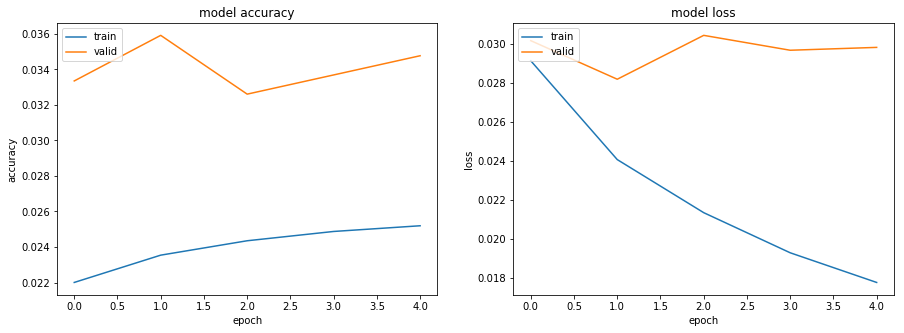

In [102]:
# summarize history for accuracy
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.plot(hist.history['acc']); plt.plot(hist.history['val_acc']);
plt.title('model accuracy'); plt.ylabel('accuracy');
plt.xlabel('epoch'); plt.legend(['train', 'valid'], loc='upper left');

# summarize history for loss
plt.subplot(1, 2, 2)
plt.plot(hist.history['loss']); plt.plot(hist.history['val_loss']);
plt.title('model loss'); plt.ylabel('loss');
plt.xlabel('epoch'); plt.legend(['train', 'valid'], loc='upper left');
plt.show()

In [103]:
print("== Reload to best weights saved...")
model.load_weights(model_fn)

== Reload to best weights saved...


In [104]:
batch_size=200 #200
prediction=model.predict([padded_x_query_train,padded_x_doc_train,exact_match_inp_train],
          batch_size=batch_size,
         )

In [105]:
prediction.shape

(74067, 1)

In [106]:
prediction[0]

array([ 0.56328869], dtype=float32)

In [107]:
def pred2relevance_categorical(prediction):
    orig_labels = [ 1.  ,  1.25 , 1.33 , 1.5 ,  1.67,  1.75,  2. ,   2.25 , 2.33  ,2.5 ,  2.67  ,2.75 ,3.  ]
    new_labels= [ 0 , 1 , 2 , 3 , 4 , 5,  6 , 7 , 8,  9, 10 ,11, 12]
    orig_labels_prediction=[]
    for preds in prediction:
        #print(preds)
        max_idx=np.argmax(preds)
        orig_labels_prediction+=[orig_labels[max_idx]]
    return np.array(orig_labels_prediction)

In [108]:
### categorical
orig_labels_prediction =  pred2relevance_categorical(prediction)
print(orig_labels_prediction[0])
from sklearn.metrics import mean_squared_error
RMSE = mean_squared_error(train_query_df['relevance'].as_matrix(), orig_labels_prediction)**0.5
print(RMSE)

1.0
1.48123156189


In [109]:
### regression
RMSE = mean_squared_error(train_query_df['relevance'].as_matrix(), (prediction*3)+1)**0.5
print(RMSE)

0.451254005288


# print("Predict")
word_a = 'wood'#raw_input('First word: ')
if word_a not in word2idx:
    print('"%s" is not in the index' % word_a)
word_b = 'fan'#raw_input('Second word: ')
if word_b not in word2idx:
    print('"%s" is not in the index' % word_b)
output = model.predict([np.asarray([word2idx[word_a]]), np.asarray([word2idx[word_b]])])
print('%f' % output)

In [110]:
test_df=test_private_df

In [111]:
test_query_sentences = []

print("Parsing sentences from search string")
for query in test_df["search_term"]:
    words,vocab = doc_to_wordlist(query, vocab, remove_stopwords=True)
    test_query_sentences += [words]
    

Parsing sentences from search string


In [112]:
len(test_query_sentences)

78419

In [113]:
test_query_word2vec_idx_list = query_sent2idx(test_query_sentences)

78419


In [114]:
test_joined_df=test_df.join(product_df.set_index('product_uid'), on='product_uid')

test_joined_doc_sentences=[]
for doc in test_joined_df['content']:
    words,vocab = doc_to_wordlist(doc, vocab, remove_stopwords=True)
    test_joined_doc_sentences += [words]
    
test_doc_word2vec_idx_list = query_sent2idx(test_joined_doc_sentences)

78419


In [115]:
x_query_test=np.array(test_query_word2vec_idx_list)[0:78419]
x_doc_test=np.array(test_doc_word2vec_idx_list)[0:78419]

# TODO: replace this with embedding with mask zero rather than padding, need to change index for encoding too, imput dim too.
print("Pad sequences (samples x time)")
x_query_test = sequence.pad_sequences(x_query_test, maxlen=query_max_len,padding='post', truncating='post', value=0.)
x_doc_test = sequence.pad_sequences(x_doc_test, maxlen=doc_max_len,padding='post', truncating='post', value=0.)
# x_query_test = sequence.pad_sequences(x_query_test, maxlen=query_max_len)
# x_doc_test = sequence.pad_sequences(x_doc_test, maxlen=doc_max_len)

# Padding for wide convolution
# Pad input with m-1 zeros from left and right. m is filter size
padded_x_query_test = sequence.pad_sequences(x_query_test, maxlen=query_max_len+(query_filter_size_m-1),\
                                      padding='post', truncating='post', value=0.)
padded_x_query_test = sequence.pad_sequences(padded_x_query_test, maxlen=query_max_len+(query_filter_size_m-1)*2,\
                                      padding='pre', truncating='pre', value=0.)
padded_x_doc_test = sequence.pad_sequences(x_doc_test, maxlen=doc_max_len+(doc_filter_size_m-1),\
                                      padding='post', truncating='post', value=0.)
padded_x_doc_test = sequence.pad_sequences(padded_x_doc_test, maxlen=doc_max_len+(doc_filter_size_m-1)*2,\
                                      padding='pre', truncating='pre', value=0.)

print('x_query_test shape:', x_query_test.shape)
print('x_doc_test shape:', x_doc_test.shape)
print('padded_x_query_test shape:', padded_x_query_test.shape)
print('padded_x_doc_test shape:', padded_x_doc_test.shape)

#TODO: y label on 0-1 scale from 1-3
#y_train=(train_query_df['relevance'].as_matrix()-1)/3

# TODO: as categorical
#y_test=to_categorical(train_query_df['relevance_int'].as_matrix(),13)
# y_test=test_query_df['relevance_int'].as_matrix()
#print('y_train shape:', y_train.shape)


Pad sequences (samples x time)
x_query_test shape: (78419, 6)
x_doc_test shape: (78419, 6)
padded_x_query_test shape: (78419, 8)
padded_x_doc_test shape: (78419, 8)


In [116]:
exact_match_list_test=[]
for i in range(x_query_test.shape[0]):
    #print(i)
    c1=x_query_test[i]
    c2=x_doc_test[i]
    #print(c1.shape[0])
    #print(c2.shape[0])

    c1_inp=np.repeat(c1,c2.shape[0],axis=0)
    c1_inp=c1_inp.reshape((c1.shape[0],c2.shape[0]))
    #print(c1_inp.shape)
    #print(c1_inp)

    #print(c2)
    c2_inp=np.tile(c2,(c1.shape[0],1))
    #print(c2_inp.shape)
    #print(c2_inp)    
    #print(c1_inp == c2_inp)
    exact_match_list_test+=[(c1_inp == c2_inp).astype(int)]

exact_match_inp_test=np.array(exact_match_list_test)
exact_match_inp_test.shape

(78419, 6, 6)

In [117]:
print(test_query_df['search_term'][0])
print(x_query_test[0])
print(x_doc_test[0])
print(exact_match_inp_test[0])

90 degree bracket
[ 484 3250  244    0    0    0]
[484 523 391  16 256 369]
[[1 0 0 0 0 0]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]]


In [118]:
batch_size=200 #200
test_prediction=model.predict([padded_x_query_test,padded_x_doc_test,exact_match_inp_test],
          batch_size=batch_size,
         )

In [119]:
test_prediction.shape

(78419, 1)

In [120]:
test_prediction[0]

array([ 0.27937871], dtype=float32)

In [121]:
### categorical
test_orig_labels_prediction =  pred2relevance_categorical(test_prediction)
print(test_orig_labels_prediction[0])
test_RMSE = mean_squared_error(test_df['relevance'].as_matrix(), test_orig_labels_prediction)**0.5
print(test_RMSE)

1.0
1.48151343796


In [122]:
### regression
test_RMSE = mean_squared_error(test_df['relevance'].as_matrix(), (test_prediction*3)+1)**0.5
print(test_RMSE)

0.544830636579


In [123]:
test_df['relevance'].as_matrix()

array([ 2.33,  2.67,  2.67, ...,  1.  ,  2.67,  2.33])

In [124]:
(test_prediction*3)+1

array([[ 1.8381362 ],
       [ 2.6492672 ],
       [ 2.35944319],
       ..., 
       [ 2.02104449],
       [ 2.15400457],
       [ 2.32568264]], dtype=float32)